# Graph Analysis

source: http://kgullikson88.github.io/blog/pypi-analysis.html

## Load the data and import libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# Graph Analysis Specific
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
from matplotlib import patches
import operator


# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

In [2]:
data_folder = '../data/'

requirements = pd.read_csv(data_folder + 'reqs.csv')
requirements.head()

,package_name,requirement
0,0.0.1,tensorflow
1,0.0.1,pandas
2,115wangpan,pycurl
3,115wangpan,six
4,115wangpan,humanize


## Defining helper functions and defaults

In [3]:
!mkdir figs
figs_dir = 'figs/'

def make_graph(df, min_edges=0):
    DG = nx.DiGraph()
    DG.add_nodes_from(df.package_name.unique())
    edges = df.loc[df.requirement.notnull(), ['package_name', 'requirement']].values
    DG.add_edges_from(edges)
    
    # Remove bad nodes
    DG.remove_nodes_from(['.', 'nan', np.nan])
    
    deg = DG.degree()
    to_remove = [n for n in dict(deg) if deg[n] <= min_edges]
    DG.remove_nodes_from(to_remove)
    return DG

A subdirectory or file figs already exists.


In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

## Export data for visualization

In [5]:
# Make a dotfile to import into gephi and make the network graph

DG = make_graph(requirements, min_edges=10)
write_dot(DG, 'requirements_graph.dot')

# create the full graph
dep_graph = make_graph(requirements, min_edges=0)

# Statistic plots

## 1: Histogram of the number of connections for the top several packages

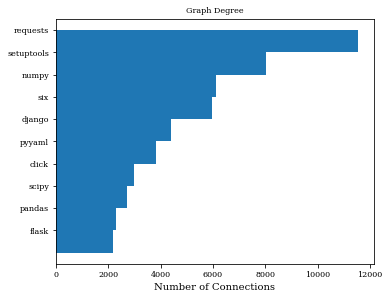

In [6]:
sorted_dict = sorted(dict(dep_graph.in_degree()).items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
ax.set_yticklabels(xlabels)
ax.set_xlabel('Number of Connections')
ax.set_title('Graph Degree')
fig.subplots_adjust(left=0.27, bottom=0.1, top=0.95)

fig.savefig(figs_dir+'Connections.pdf')
fig.savefig(figs_dir+'Connections.png', dpi=300)

In [35]:
# Write to dict to save to CSV later on
in_deg_dict = dict(dep_graph.in_degree())
df_in = pd.DataFrame(data={
    'package': list(in_deg_dict.keys()),
    'in-degree': list(in_deg_dict.values()),
})
df_in.set_index('package', inplace=True)
df = df_in

In [36]:
# Write to dict to save to CSV later on
out_deg_dict = dict(dep_graph.out_degree())
df_out = pd.DataFrame(data={
    'package': list(out_deg_dict.keys()),
    'out-degree': list(out_deg_dict.values()),
})
df_out.set_index('package', inplace=True)

In [40]:
df = df.merge(df_out, left_index=True, right_index=True)

## PageRank

Similar to the node degree, but with some extra magic.

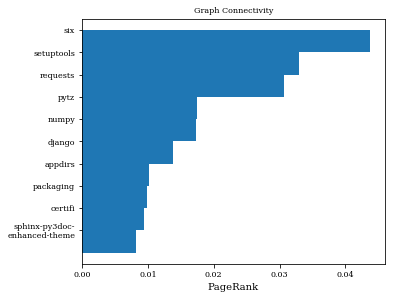

In [29]:
pr = nx.link_analysis.pagerank_scipy(dep_graph)
sorted_dict = sorted(pr.items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
xlabels[0] = 'sphinx-py3doc-\nenhanced-theme'
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
ax.set_yticklabels(xlabels)
ax.set_xlabel('PageRank')
ax.set_title('Graph Connectivity')
fig.subplots_adjust(left=0.30, bottom=0.1, top=0.95)

fig.savefig(figs_dir+'PageRank.pdf')
fig.savefig(figs_dir+'PageRank.png', dpi=300)

# Centrality Measures

The statistics above are basically degree centrality measures, but there are actual statistics that look at it too.

- **Betweenness Centrality** The betweenness centrality of node n is defined as the proportion of best paths between any other pairs of nodes which pass through n.

Yep, this has a really fast cutoff, with the vast majority of packages having very few connections. The black line shows where there is one package in the bin. It's basically a power-law, which arises in a "rich get richer" model. In other words, some packages (the ones with very high degree) are required by many things, so new packages also require them. They also tend to be older packages, which means they've had longer to accumulate packages that depend on them.

In [ ]:
# This takes more than 2 hours!
bc = nx.betweenness_centrality(dep_graph)

In [ ]:
sorted_dict = sorted(bc.items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1]*100 for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
ax.set_yticklabels(xlabels)
ax.set_xlabel('Betweenness Connectivity (%)')
fig.subplots_adjust(left=0.32, bottom=0.1, top=0.95)

fig.savefig(figs_dir+'Betweenness.pdf')
fig.savefig(figs_dir+'Betweenness.png', dpi=300)

In [ ]:
df_bc = pd.DataFrame(data={
    'package': list(bc.keys()),
    'bc': list(bc.values()),
})
df_bc.set_index('package', inplace=True)

In [ ]:
df = df.merge(df_bc, left_index=True, right_index=True)

# Is this a small-world graph?

Compute both the average path length and the clustering coefficient. Small worlds have large clustering coefficients and small average path lengths.

In [41]:
avg_pathlen = []
subgraph_size = []
for subgraph in nx.connected_component_subgraphs(dep_graph.to_undirected()):
    n = len(subgraph)
    if n > 1:
        subgraph_size.append(n)
        avg_pathlen.append(nx.average_shortest_path_length(subgraph))

avg_clustering = nx.average_clustering(dep_graph.to_undirected())
apl = np.average(avg_pathlen, weights=subgraph_size)
print(apl, avg_clustering)

KeyboardInterrupt: 

So I'm not sure... by the definition above, the clustering coefficient seems to be quite small. That means that node neighborhoods are not connected anywhere near as much as they could be, and that this is NOT a small-world graph. On the other hand, the average path length $L \sim \log{N}$, which is another definition of a small-world graph. I guess these could be reconciled if there are a few very very important nodes that act as hubs, but the "spokes" that come out of the hubs are relatively independent. Those hubs appear to be `requests` and `django`, and maybe `six`.

# Matrix Graph

(code taken from the [StackOverflow](http://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern))

The nodes are partitioned using the [`community`](https://pypi.python.org/pypi/python-louvain/0.3) code, which separates a large graph into communities as follows:

1. Start with all nodes in their own communities
2. For each node, test if the "modularity" increases by putting it into the same community as one of it's neighbors (one of the nodes it is connected to)
3. Continue until no more gain is found
4. Make a NEW network where each node is now the communities found in the above set.
5. Repeat steps 1-3 many times, until the modularity no longer increases.

Details on the algorithm can be found [here](http://arxiv.org/abs/0803.0476). You might notice that this algorithm is basically creating a dendrogram of the network.

In [ ]:
from scipy.sparse import coo_matrix

def plot_coo_matrix(m, partitions=None, colors=None):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
        
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, facecolor='white')
    ax.plot(m.col, m.row, 's', color='black', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    if partitions is None and colors is None:
        return
    
    assert len(partitions) == len(colors)
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)
    return 

def find_closest(G, node, node_list):
    """ Find which node in node_list the given node is closest to
    """
    min_pathlen = np.inf
    best_node = "Isolated"
    for n in node_list:
        if nx.has_path(G, node, n):
            length = nx.shortest_path_length(G, node, n)
            if length < min_pathlen:
                min_pathlen = length
                best_node = n
    return best_node

In [ ]:
import community

#first compute the best partition
partition = community.best_partition(dep_graph.to_undirected())

In [ ]:
from collections import defaultdict

louvain_comms = defaultdict(list)
for node_index, comm_id in partition.items():
    louvain_comms[comm_id].append(node_index)
louvain_comms = list(louvain_comms.values())

nodes_ordered = [node for comm in louvain_comms for node in comm]
matrix = nx.adjacency_matrix(dep_graph, nodelist=nodes_ordered)

plot_coo_matrix(matrix)

fig.savefig(figs_dir+'AdjacencyGraph.pdf')
fig.savefig(figs_dir+'AdjacencyGraph.png', dpi=300)

## What do the communities signify?
I will try to find the significance of the 8 large communities shown in the figure above.

In [ ]:
# Get the size of each community
comm_size = {i: len(louvain_comms[i]) for i in range(len(louvain_comms))}

# Sort by size
big_community_sizes = sorted(comm_size.items(), key=operator.itemgetter(1), reverse=True)[:10]

# Get the packages in each of the communities
big_communities = [louvain_comms[i] for i in sorted([c for c, s in big_community_sizes])]

In [ ]:
def plot_community(i, N=5):
    # Make a subgraph
    subgraph = dep_graph.subgraph(big_communities[i])

    # Find the most important nodes in the subgraph:
    pr = nx.link_analysis.pagerank_scipy(subgraph)
    sorted_dict = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)

    N = 5
    x = np.arange(N)
    y = np.array([d[1] for d in sorted_dict[:N]])
    xlabels = [d[0] for d in sorted_dict[:N]][::-1]
    fig, (left, right) = plt.subplots(1, 2, figsize=(13, 7))

    left.barh(x[::-1], y, height=1.0)
    left.set_yticks(x + 0.5)
    _ = left.set_yticklabels(xlabels)
    left.set_xlabel('PageRank')
    left.set_title('Graph Connectivity')
    fig.subplots_adjust(left=0.30, bottom=0.1, top=0.95)

    alpha = 200.0/len(subgraph.nodes())
    print(alpha)
    nx.draw(subgraph, ax=right, node_size=10, alpha=alpha)

In [ ]:
# Flask and web framework development
plot_community(i=0)

In [ ]:
# Not sure. redis is a data store, and tornado is a kind of web server. 
#tornado and pyzmq get used in jupyter notebook, but that is not in this community...
plot_community(i=1)

In [ ]:
#pydata
plot_community(i=2)

In [ ]:
# Testing and documentation
plot_community(i=3)

In [ ]:
# Django dominates this community, so probably just django/dynamic websites
plot_community(i=4)

In [ ]:
# web scraping/interfacing
plot_community(i=5)

In [ ]:
# zope/distribute (which is really a dependency of almost everything)
plot_community(i=6)

In [ ]:
# yaml and jinja2 are website templating stuff. Maybe this is more the static web stuff in comparison to django?
plot_community(i=7)

In [ ]:
# This appears to be relatively small utility functions for python
plot_community(i=8)

In [ ]:
# pyramid is a web framework. sqlalchemy is a SQL interface to python. Not really sure here...
plot_community(i=9)